# Image Pre-processing

In this notebook we will show you how to denoise medical images and how to correct bias field inhomogeneities that can occur in MRI images.

But first we need install the required libraries to more easily perform these image pre-processing steps

In [1]:
#@title Install required libraries
#@markdown In this notebook, we will mainly rely on a library called SimpleITK.

#@markdown [SimpleITK](https://simpleitk.org) is an open-source wrapper (for Python, R, Java, C#, Lua, Ruby, TCL) of a widely used C++ library providing segmentation, registration, and filtering functions to process multi-dimensional images.

# command to install a library is: !pip install <library_name>
# we may choose a specific version by using !pip install <library_name>==<version>
# !pip install SimpleITK==2.0.0
# !pip install --upgrade --pre SimpleITK --find-links https://github.com/SimpleITK/releases/tag/latest
!pip install --upgrade --pre SimpleITK --find-links https://github.com/SimpleITK/SimpleITK/releases/tag/latest
!pip install pywavelets

Looking in links: https://github.com/SimpleITK/SimpleITK/releases/tag/latest
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 8.9 MB/s eta 0:00:00


In [2]:
#@title Download data

#@markdown For simplicity, we will show you how to denoise and correct the bias field inhomogeneities on a single MRI image volume. We will download the image using the following code.

!wget --max-redirect=20 -O prostate_example.nii.gz https://www.dropbox.com/s/xypjy4x5do9qtw8/prostate_example.nii.gz

--2023-09-21 09:59:22--  https://www.dropbox.com/s/xypjy4x5do9qtw8/prostate_example.nii.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/xypjy4x5do9qtw8/prostate_example.nii.gz [following]
--2023-09-21 09:59:22--  https://www.dropbox.com/s/raw/xypjy4x5do9qtw8/prostate_example.nii.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6978d4606c249ed081a298a9c5.dl.dropboxusercontent.com/cd/0/inline/CEIIssdAiYFYkYbtKtl52HErD3uL0u1wYdCjk1n_X4BZ3dtRRo566aaG8-c5tasFz3wEbsLSpQtiQ9xLdVz2UnyPYkMi2IY_4QdjSUL5g2vrZkBg7FSb2GJq_VrxbtYUdGOeixBu6O-h-___BHLL4QDI/file# [following]
--2023-09-21 09:59:23--  https://uc6978d4606c249ed081a298a9c5.dl.dropboxusercontent.com/cd/0/inline/CEIIssdAiYFYkYbtKtl52HErD3uL0u1wYdCjk1n_X4BZ3dtRRo566aaG8-c5tasFz3wEb

In [3]:
#@title Import libraries

#@markdown As previously said, we will use python libraries to facilitate our job executing each of the pre-processing steps.

#@markdown Some of these may already be available, thus not requiring installation (e.g., [matplotlib](https://matplotlib.org)), while others may be installed as dependencies of other libraries installed. In order to use these libraries, we must import them as follows.

import SimpleITK as sitk
import matplotlib.pyplot as plt

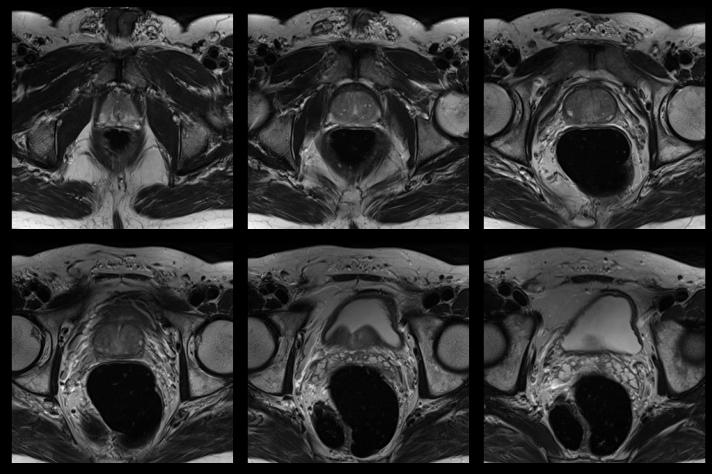

In [ ]:
#@title Read example T2-weighted prostate MRI

#@markdown We will use SimpleITK and matplotlib.pyplot to display some slices of the prostate MRI T2-weighted scan to read the image.

# read prostate MRI image (3D volume) and assign it to the variable image
image = sitk.ReadImage('prostate_example.nii.gz')

# select a couple of slices to display
fig, axes = plt.subplots (nrows = 2, ncols = 3, figsize = (10, 10))
rect = fig.patch
rect.set_facecolor('black')

axes[0,0].imshow(sitk.GetArrayFromImage(image)[3,:,:], cmap='gray')
axes[0,1].imshow(sitk.GetArrayFromImage(image)[5,:,:], cmap='gray')
axes[0,2].imshow(sitk.GetArrayFromImage(image)[8,:,:], cmap='gray')
axes[1,0].imshow(sitk.GetArrayFromImage(image)[10,:,:], cmap='gray')
axes[1,1].imshow(sitk.GetArrayFromImage(image)[12,:,:], cmap='gray')
axes[1,2].imshow(sitk.GetArrayFromImage(image)[14,:,:], cmap='gray')

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=-15, w_pad=1)

As can be seen there are low-frequency and very smooth drifts in intensity within tissues that should have more or less the same intensity. Inhomogeneities in the scanner magnetic field cause these drifts.

In [ ]:
#@title Create copy of image in float 32-bits

#@markdown Originally our image was saved in 16-bits. This means that each voxel in the image has a depth of information that can occupy 16-bits.

#@markdown To not lose information, some filters we will use require us to input 32-bits float images to avoid the loss of precision in their internal operations, and therefore the output.

#@markdown But don't worry! Going from 16-bits to 32-bits (lower to higher bit depth) is very easy. You can use the following function to that.

# cast image voxel bit depth to 32-bits
image_float32 = sitk.Cast(image,sitk.sitkFloat32)

However, you may be asking what about going from higher to lower bit depth. This procedure requires additional steps to ensure that this is done properly, as shown in **Appendix 1 - which you can visit and test later**.  

Now that we have introduced a required preparation of images to execute some filters, let's try to start by correcting the bias field inhomogeneities artifacts.

In [ ]:
#@title Bias field inhomogeneities correction

#@markdown We will now try to correct these bias field inhomogeneities in our image using the following widely used function.

#@markdown This filter takes a bit running (in the meantime, if you want to understand the causes of these inhomogeneities, you can read the comment and visit the link to learn more).

#@markdown [Documentation of N4 Bias Field Correction filter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1N4BiasFieldCorrectionImageFilter.html)

# instantiate the filter and set options to execute with our image
bias_field_filter = sitk.N4BiasFieldCorrectionImageFilter()
bias_field_filter.SetNumberOfControlPoints([4,4,4])
bias_field_filter.UseMaskLabelOff()
bias_corrected_image = bias_field_filter.Execute(image_float32)

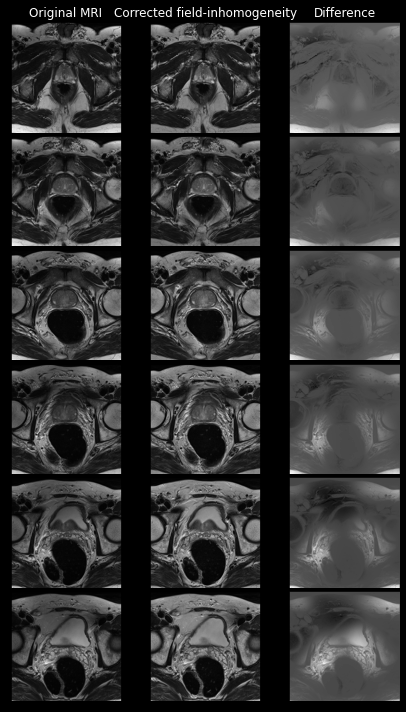

In [ ]:
#@markdown Plot the same slices as before and on the side the bias field inhomogeneities corrected images
fig, axes = plt.subplots (nrows = 6, ncols = 3, figsize = (10, 10))
rect = fig.patch
rect.set_facecolor('black')

axes[0,0].imshow(sitk.GetArrayFromImage(image)[3,:,:], cmap='gray')
axes[0,1].imshow(sitk.GetArrayFromImage(bias_corrected_image)[3,:,:], cmap='gray')
axes[0,2].imshow(sitk.GetArrayFromImage(-bias_corrected_image)[3,:,:]+sitk.GetArrayFromImage(image)[3,:,:], cmap='gray')
axes[0,0].set_title('Original MRI', color='w')
axes[0,1].set_title('Corrected field-inhomogeneity', color='w')
axes[0,2].set_title('Difference', color='w')
axes[1,0].imshow(sitk.GetArrayFromImage(image)[5,:,:], cmap='gray')
axes[1,1].imshow(sitk.GetArrayFromImage(bias_corrected_image)[5,:,:], cmap='gray')
axes[1,2].imshow(sitk.GetArrayFromImage(-bias_corrected_image)[5,:,:]+sitk.GetArrayFromImage(image)[5,:,:], cmap='gray')
axes[2,0].imshow(sitk.GetArrayFromImage(image)[8,:,:], cmap='gray')
axes[2,1].imshow(sitk.GetArrayFromImage(bias_corrected_image)[8,:,:], cmap='gray')
axes[2,2].imshow(sitk.GetArrayFromImage(-bias_corrected_image)[8,:,:]+sitk.GetArrayFromImage(image)[8,:,:], cmap='gray')
axes[3,0].imshow(sitk.GetArrayFromImage(image)[10,:,:], cmap='gray')
axes[3,1].imshow(sitk.GetArrayFromImage(bias_corrected_image)[10,:,:], cmap='gray')
axes[3,2].imshow(sitk.GetArrayFromImage(-bias_corrected_image)[10,:,:]+sitk.GetArrayFromImage(image)[10,:,:], cmap='gray')
axes[4,0].imshow(sitk.GetArrayFromImage(image)[12,:,:], cmap='gray')
axes[4,1].imshow(sitk.GetArrayFromImage(bias_corrected_image)[12,:,:], cmap='gray')
axes[4,2].imshow(sitk.GetArrayFromImage(-bias_corrected_image)[12,:,:]+sitk.GetArrayFromImage(image)[12,:,:], cmap='gray')
axes[5,0].imshow(sitk.GetArrayFromImage(image)[14,:,:], cmap='gray')
axes[5,1].imshow(sitk.GetArrayFromImage(bias_corrected_image)[14,:,:], cmap='gray')
axes[5,2].imshow(sitk.GetArrayFromImage(-bias_corrected_image)[14,:,:]+sitk.GetArrayFromImage(image)[14,:,:], cmap='gray')

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=0, w_pad=-25)

In [ ]:
#@title Denoising MRI
#@markdown Medical images can be affected by several types of noise. It is possible to use the noise type information to apply specific denoising filters properly developed for such noise types.

#@markdown However, in most cases, images may not be affected by a single type of noise. While we wish to remove the noise, we do not want to lose the details of fine structures; therefore, a common class of filters used are the edge-preserving denoising filters.

#@markdown In medical image pre-processing, a common type of denoising filters used are the anisotropic diffusion-based filters (e.g., Gradient Anisotropic Diffusion and Curvature Anisotropic Diffusion).

#@markdown In this case, we will use the Curvature Anisotropic Diffusion as it compares with other non-linear diffusion techniques and, in comparison with the Gradient Anisotropic Diffusion, can better preserve finer detailed structures due to its less sensitivity to contrast.

#@markdown In Appendix 2, we show how you can execute the Gradient Anisotropic Diffusion filter, and we compare its output with the one from Curvature Anisotropic Diffusion.

#@markdown [Documentation of Curvature Anisotropic Diffusion filter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1CurvatureAnisotropicDiffusionImageFilter.html)

#@markdown [Documentation of Gradient Anisotropic Diffusion filter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1GradientAnisotropicDiffusionImageFilter.html)

denoised_image = sitk.CurvatureAnisotropicDiffusion(bias_corrected_image)

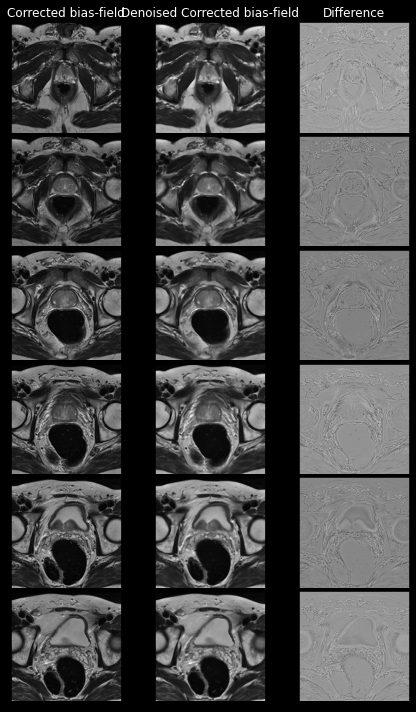

In [ ]:
#@title
fig, axes = plt.subplots (nrows = 6, ncols = 3, figsize = (10, 10))
rect = fig.patch
rect.set_facecolor('black')

axes[0,0].imshow(sitk.GetArrayFromImage(bias_corrected_image)[3,:,:], cmap='gray')
axes[0,1].imshow(sitk.GetArrayFromImage(denoised_image)[3,:,:], cmap='gray')
axes[0,2].imshow(sitk.GetArrayFromImage(denoised_image)[3,:,:]-sitk.GetArrayFromImage(bias_corrected_image)[3,:,:], cmap='gray')
axes[0,0].set_title('Corrected bias-field', color='w')
axes[0,1].set_title('Denoised Corrected bias-field', color='w')
axes[0,2].set_title('Difference', color='w')
axes[1,0].imshow(sitk.GetArrayFromImage(bias_corrected_image)[5,:,:], cmap='gray')
axes[1,1].imshow(sitk.GetArrayFromImage(denoised_image)[5,:,:], cmap='gray')
axes[1,2].imshow(sitk.GetArrayFromImage(denoised_image)[5,:,:]-sitk.GetArrayFromImage(bias_corrected_image)[5,:,:], cmap='gray')
axes[2,0].imshow(sitk.GetArrayFromImage(bias_corrected_image)[8,:,:], cmap='gray')
axes[2,1].imshow(sitk.GetArrayFromImage(denoised_image)[8,:,:], cmap='gray')
axes[2,2].imshow(sitk.GetArrayFromImage(denoised_image)[8,:,:]-sitk.GetArrayFromImage(bias_corrected_image)[8,:,:], cmap='gray')
axes[3,0].imshow(sitk.GetArrayFromImage(bias_corrected_image)[10,:,:], cmap='gray')
axes[3,1].imshow(sitk.GetArrayFromImage(denoised_image)[10,:,:], cmap='gray')
axes[3,2].imshow(sitk.GetArrayFromImage(denoised_image)[10,:,:]-sitk.GetArrayFromImage(bias_corrected_image)[10,:,:], cmap='gray')
axes[4,0].imshow(sitk.GetArrayFromImage(bias_corrected_image)[12,:,:], cmap='gray')
axes[4,1].imshow(sitk.GetArrayFromImage(denoised_image)[12,:,:], cmap='gray')
axes[4,2].imshow(sitk.GetArrayFromImage(denoised_image)[12,:,:]-sitk.GetArrayFromImage(bias_corrected_image)[12,:,:], cmap='gray')
axes[5,0].imshow(sitk.GetArrayFromImage(bias_corrected_image)[14,:,:], cmap='gray')
axes[5,1].imshow(sitk.GetArrayFromImage(denoised_image)[14,:,:], cmap='gray')
axes[5,2].imshow(sitk.GetArrayFromImage(denoised_image)[14,:,:]-sitk.GetArrayFromImage(bias_corrected_image)[14,:,:], cmap='gray')

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=0, w_pad=-25)

In [ ]:
#@title Appendix 1 - Casting and Image bit depth

#@markdown **Casting images from higher bit depth to lower bit depth**

#@markdown To perform this operation, we have to consider the maximum value of the desired bit depth.

#@markdown * unsigned 8-bits (UInt8) - ranges from 0 to 255
#@markdown * signed 8-bits (Int8) - ranges from -127 to 127
#@markdown * unsigned 16-bits (UInt16) - ranges from 0 to 65535
#@markdown * signed 16-bits (Int16) - ranges from -32768 to 32767
#@markdown * ... and so on.

#@markdown So imagine that we have an UInt16 image that we want to cast to UInt8.

#@markdown If we just cast the 16-bits image to 8-bits we may lose information. Let's try it

image_16b_to_8b = sitk.Cast(image, sitk.sitkUInt8)

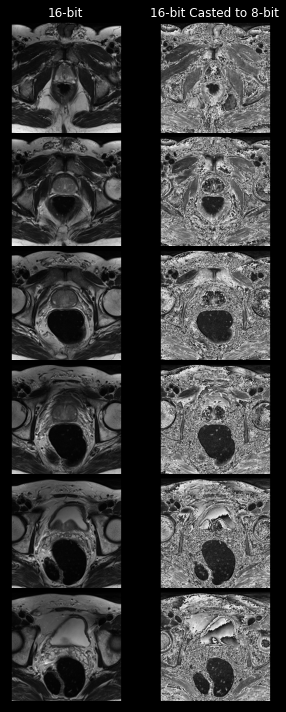

In [ ]:
#@title
fig, axes = plt.subplots (nrows = 6, ncols = 2, figsize = (10, 10))
rect = fig.patch
rect.set_facecolor('black')

axes[0,0].imshow(sitk.GetArrayFromImage(image)[3,:,:], cmap='gray')
axes[0,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[3,:,:], cmap='gray')
axes[0,0].set_title('16-bit', color='w')
axes[0,1].set_title('16-bit Casted to 8-bit', color='w')
axes[1,0].imshow(sitk.GetArrayFromImage(image)[5,:,:], cmap='gray')
axes[1,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[5,:,:], cmap='gray')
axes[2,0].imshow(sitk.GetArrayFromImage(image)[8,:,:], cmap='gray')
axes[2,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[8,:,:], cmap='gray')
axes[3,0].imshow(sitk.GetArrayFromImage(image)[10,:,:], cmap='gray')
axes[3,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[10,:,:], cmap='gray')
axes[4,0].imshow(sitk.GetArrayFromImage(image)[12,:,:], cmap='gray')
axes[4,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[12,:,:], cmap='gray')
axes[5,0].imshow(sitk.GetArrayFromImage(image)[14,:,:], cmap='gray')
axes[5,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[14,:,:], cmap='gray')

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=0, w_pad=-25)

To correctly cast an image from a higher to a lower bit depth, we need to rescale the image intensities to ensure all the intensities can be depicted in this lower bit depth.

This rescaling may cause some loss of information but considerably less than a simple casting, as you will see in the next example.

In [ ]:
#@markdown To correctly cast an image from a higher to a lower bit depth, we need to rescale the image intensities to ensure all the intensities can be depicted in this lower bit depth.

#@markdown This rescaling may cause some loss of information but considerably less than a simple casting, as you will see in the next example.

# rescale image intensities to be within unsigned 8-bit depth (0-255)
rescaled_image = sitk.RescaleIntensity(image, outputMinimum=0, outputMaximum=255)
image_16b_to_8b = sitk.Cast(rescaled_image, sitk.sitkUInt8)

Let's now visualize the original 16-bit and the rescaled casted to 8-bit depth image

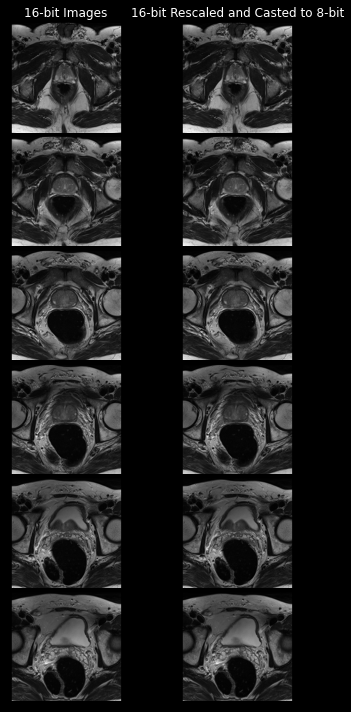

In [ ]:
#@markdown Let's now visualize the original 16-bit and the rescaled casted to 8-bit depth image
fig, axes = plt.subplots (nrows = 6, ncols = 2, figsize = (10, 10))
rect = fig.patch
rect.set_facecolor('black')

axes[0,0].imshow(sitk.GetArrayFromImage(image)[3,:,:], cmap='gray')
axes[0,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[3,:,:], cmap='gray')
axes[0,0].set_title('16-bit Images', color='w')
axes[0,1].set_title('16-bit Rescaled and Casted to 8-bit', color='w')
axes[1,0].imshow(sitk.GetArrayFromImage(image)[5,:,:], cmap='gray')
axes[1,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[5,:,:], cmap='gray')
axes[2,0].imshow(sitk.GetArrayFromImage(image)[8,:,:], cmap='gray')
axes[2,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[8,:,:], cmap='gray')
axes[3,0].imshow(sitk.GetArrayFromImage(image)[10,:,:], cmap='gray')
axes[3,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[10,:,:], cmap='gray')
axes[4,0].imshow(sitk.GetArrayFromImage(image)[12,:,:], cmap='gray')
axes[4,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[12,:,:], cmap='gray')
axes[5,0].imshow(sitk.GetArrayFromImage(image)[14,:,:], cmap='gray')
axes[5,1].imshow(sitk.GetArrayFromImage(image_16b_to_8b)[14,:,:], cmap='gray')

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=0, w_pad=-25)

In [ ]:
#@title Appendix 2 - Comparison betwenn Curvature and Gradient Anisotropic Diffusion filter

#@markdown Let's filter the bias field corrected image using the Gradient Anisotropic Diffusion filter.
denoised_grad_ani_dif_image = sitk.GradientAnisotropicDiffusion(bias_corrected_image)

Let's plot the filtered images and difference to compare.

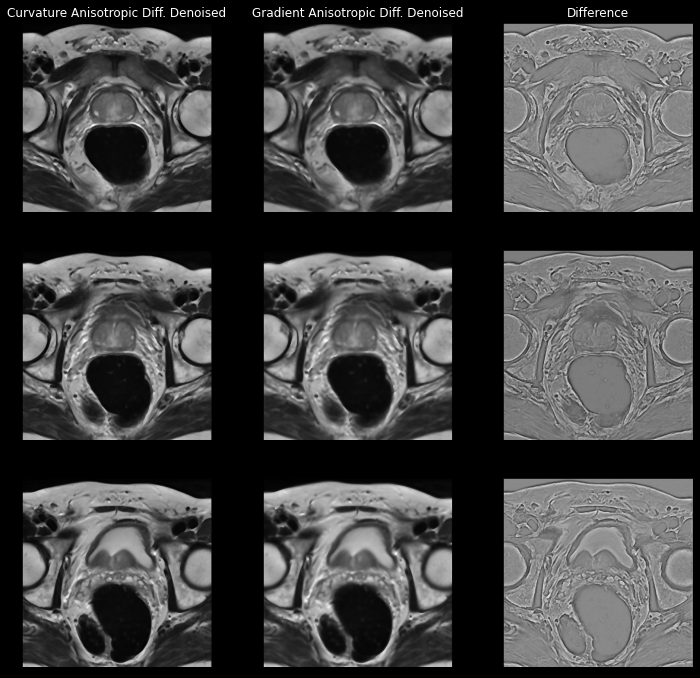

In [ ]:
#@markdown Let's plot the filtered images and difference to compare.
fig, axes = plt.subplots (nrows = 3, ncols = 3, figsize = (10, 10))
rect = fig.patch
rect.set_facecolor('black')

axes[0,0].imshow(sitk.GetArrayFromImage(denoised_image)[8,:,:], cmap='gray')
axes[0,1].imshow(sitk.GetArrayFromImage(denoised_grad_ani_dif_image)[8,:,:], cmap='gray')
axes[0,2].imshow(sitk.GetArrayFromImage(denoised_image)[8,:,:]-sitk.GetArrayFromImage(denoised_grad_ani_dif_image)[8,:,:], cmap='gray')
axes[0,0].set_title('Curvature Anisotropic Diff. Denoised', color='w')
axes[0,1].set_title('Gradient Anisotropic Diff. Denoised', color='w')
axes[0,2].set_title('Difference', color='w')
axes[1,0].imshow(sitk.GetArrayFromImage(denoised_image)[10,:,:], cmap='gray')
axes[1,1].imshow(sitk.GetArrayFromImage(denoised_grad_ani_dif_image)[10,:,:], cmap='gray')
axes[1,2].imshow(sitk.GetArrayFromImage(denoised_image)[10,:,:]-sitk.GetArrayFromImage(denoised_grad_ani_dif_image)[10,:,:], cmap='gray')
axes[2,0].imshow(sitk.GetArrayFromImage(denoised_image)[12,:,:], cmap='gray')
axes[2,1].imshow(sitk.GetArrayFromImage(denoised_grad_ani_dif_image)[12,:,:], cmap='gray')
axes[2,2].imshow(sitk.GetArrayFromImage(denoised_image)[12,:,:]-sitk.GetArrayFromImage(denoised_grad_ani_dif_image)[12,:,:], cmap='gray')

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=0, w_pad=0)

As you can see the image on the left (denoised with Curvature Anisotropic Diffusion filtering) more clearly depicts edges than the image on the right (denoised with Gradient Anisotropic Diffusion filtering).

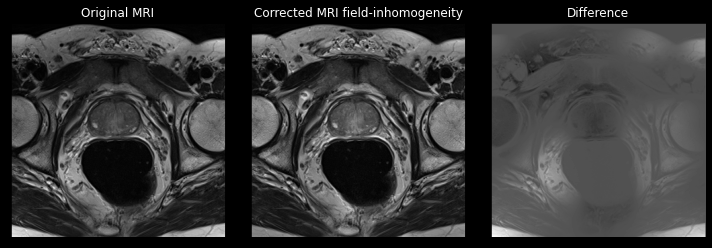

In [ ]:
#@markdown Plot the same slices as before and on the side the bias field inhomogeneities corrected images
fig, axes = plt.subplots (nrows = 1, ncols = 3, figsize = (10, 10))
rect = fig.patch
rect.set_facecolor('black')

axes[0].imshow(sitk.GetArrayFromImage(image)[8,:,:], cmap='gray')
axes[1].imshow(sitk.GetArrayFromImage(bias_corrected_image)[8,:,:], cmap='gray')
axes[2].imshow(sitk.GetArrayFromImage(-bias_corrected_image)[8,:,:]+sitk.GetArrayFromImage(image)[8,:,:], cmap='gray')
# axes[2].imshow(sitk.GetArrayFromImage(denoised_image)[8,:,:], cmap='gray')
axes[0].set_title('Original MRI', color='w')
axes[1].set_title('Corrected MRI field-inhomogeneity', color='w')
axes[2].set_title('Difference', color='w')

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=0, w_pad=0)

In [ ]:
#@markdown Plot the same slices as before and on the side the bias field inhomogeneities corrected images
fig, axes = plt.subplots (nrows = 1, ncols = 3, figsize = (10, 10))
rect = fig.patch
rect.set_facecolor('black')

axes[0].imshow(sitk.GetArrayFromImage(image)[8,:,:], cmap='gray')
axes[1].imshow(sitk.GetArrayFromImage(bias_corrected_image)[8,:,:], cmap='gray')
axes[2].imshow(sitk.GetArrayFromImage(-bias_corrected_image)[8,:,:]+sitk.GetArrayFromImage(image)[8,:,:], cmap='gray')
# axes[2].imshow(sitk.GetArrayFromImage(denoised_image)[8,:,:], cmap='gray')
axes[0].set_title('Original MRI', color='w')
axes[1].set_title('Corrected MRI field-inhomogeneity', color='w')
axes[2].set_title('Difference', color='w')

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=0, w_pad=0)

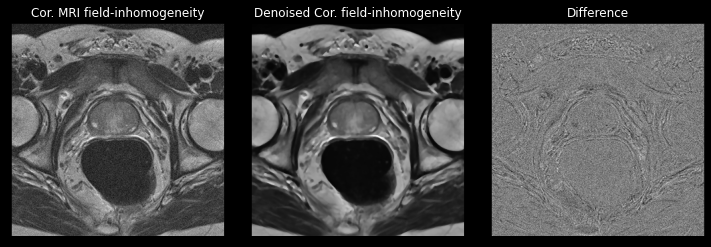

In [ ]:
#@markdown Plot the same slices as before and on the side the bias field inhomogeneities corrected images
fig, axes = plt.subplots (nrows = 1, ncols = 3, figsize = (10, 10))
rect = fig.patch
rect.set_facecolor('black')
noisy = sitk.AdditiveGaussianNoise(bias_corrected_image, 50)
axes[0].imshow(sitk.GetArrayFromImage(noisy)[8,:,:], cmap='gray')
axes[1].imshow(sitk.GetArrayFromImage(denoised_image)[8,:,:], cmap='gray')
axes[2].imshow(sitk.GetArrayFromImage(denoised_image)[8,:,:]-sitk.GetArrayFromImage(noisy)[8,:,:], cmap='gray')
axes[0].set_title('Cor. MRI field-inhomogeneity', color='w')
axes[1].set_title('Denoised Cor. field-inhomogeneity', color='w')
axes[2].set_title('Difference', color='w')

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=0, w_pad=0)



In [ ]:
noisy = sitk.AdditiveGaussianNoise(bias_corrected_image, 100)
denoised_noisy_image = sitk.CurvatureAnisotropicDiffusion(noisy)

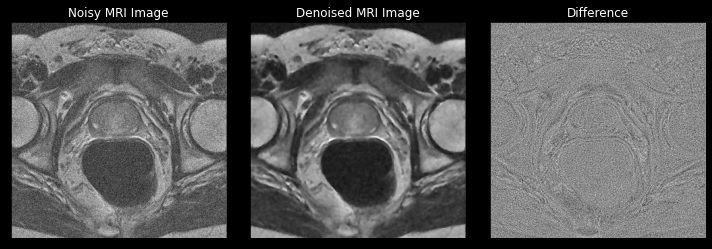

In [ ]:
#@markdown Plot the same slices as before and on the side the bias field inhomogeneities corrected images
fig, axes = plt.subplots (nrows = 1, ncols = 3, figsize = (10, 10))
rect = fig.patch
rect.set_facecolor('black')

axes[0].imshow(sitk.GetArrayFromImage(noisy)[8,:,:], cmap='gray')
axes[1].imshow(sitk.GetArrayFromImage(denoised_noisy_image)[8,:,:], cmap='gray')
axes[2].imshow(sitk.GetArrayFromImage(denoised_noisy_image)[8,:,:]-sitk.GetArrayFromImage(noisy)[8,:,:], cmap='gray')
axes[0].set_title('Noisy MRI Image', color='w')
axes[1].set_title('Denoised MRI Image', color='w')
axes[2].set_title('Difference', color='w')

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=0, w_pad=2)

In [ ]:
image
bias_corrected_image
denoised_image

In [ ]:
# for Google Colab only
!pip install -q imjoy scikit-image itk itkwidgets

     |████████████████████████████████| 3.4MB 14.6MB/s 
     |████████████████████████████████| 870kB 42.8MB/s 
     |████████████████████████████████| 2.2MB 37.3MB/s 
     |████████████████████████████████| 276kB 58.2MB/s 
     |████████████████████████████████| 112kB 49.4MB/s 


In [ ]:
from imjoy import api
from urllib.request import urlretrieve
import os
import numpy as np
import itk
from itkwidgets.trait_types import itkimage_to_json, itkimage_from_json
from itkwidgets._transform_types import to_itk_image

# register an encoder for encoding the itk.Image, the name `itkimage` will be used for decoding
# this example only use the encoder part
api.registerCodec({'name': 'itkimage', 'type': itk.Image, 'encoder': itkimage_to_json, 'decoder': itkimage_from_json})



In [ ]:
itk_image = np.random.randint(0, 255, [30, 30, 30], dtype='uint8')
class ImJoyPlugin():
    def setup(self):
        api.log('plugin initialized')

    async def run(self, ctx):
        # here the itk_image will be encoded via the registered encoder function (i.e.: itkimage_to_json)
        # it may take a while until the data is transferred to the viewer in Colab
        viewer = await api.createWindow(src="https://oeway.github.io/itk-vtk-viewer/")
        await viewer.setImage(itk_image)


In [ ]:
itk_image = to_itk_image(image)
api.export(ImJoyPlugin())

<Future finished result=[]>